# GAE Training

Train the Graph Autoencoder model for anomaly detection.


In [1]:
import torch
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)


## Configuration


In [2]:
DATA_DIR = "data"
MODEL_DIR = "models"

HIDDEN_DIM = 128
LATENT_DIM = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.05
WEIGHT_DECAY = 0

Path(MODEL_DIR).mkdir(exist_ok=True)

print(f"Data: {DATA_DIR}/")
print(f"Model: {MODEL_DIR}/")
print(f"Hidden: {HIDDEN_DIM}, Latent: {LATENT_DIM}")
print(f"Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE}")


Data: data/
Model: models/
Hidden: 128, Latent: 64
Epochs: 200, LR: 0.05


## Load Training Graph


In [3]:
train_graph = torch.load(Path(DATA_DIR) / "train_graph.pt", weights_only=False)

print(f"Training graph loaded:")
print(f"  Nodes: {train_graph.num_nodes:,}")
print(f"  Edges: {train_graph.num_edges:,}")
print(f"  Features: {train_graph.num_node_features}")
print(f"  Attack nodes: {(train_graph.y == 1).sum().item()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")
train_graph = train_graph.to(device)


Training graph loaded:
  Nodes: 190,645
  Edges: 2,083,431
  Features: 299
  Attack nodes: 0

Device: cuda


## Initialize Model


In [4]:
from utils import GAE, train_gae

model = GAE(
    input_dim=train_graph.num_node_features,
    hidden_dim=HIDDEN_DIM,
    latent_dim=LATENT_DIM
).to(device)

print(f"Model initialized:")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")


Model initialized:
  Parameters: 46,656


## Train Model


In [5]:
print(f"Training for {NUM_EPOCHS} epochs...")
print("=" * 60)

model, losses = train_gae(
    model,
    train_graph,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    verbose=True,
    print_every=10
)

print("=" * 60)
print(f"Training complete!")
print(f"  Final loss: {losses[-1]:.4f}")
print(f"  Best loss: {min(losses):.4f} (epoch {losses.index(min(losses))+1})")


Training for 200 epochs...
Epoch 10/200, Loss: 1.0684
Epoch 20/200, Loss: 0.8809
Epoch 30/200, Loss: 0.8215
Epoch 40/200, Loss: 0.7970
Epoch 50/200, Loss: 0.7837
Epoch 60/200, Loss: 0.7783
Epoch 70/200, Loss: 0.7753
Epoch 80/200, Loss: 0.7720
Epoch 90/200, Loss: 0.7696
Epoch 100/200, Loss: 0.7674
Epoch 110/200, Loss: 0.7682
Epoch 120/200, Loss: 0.7668
Epoch 150/200, Loss: 0.7647
Epoch 160/200, Loss: 0.7640
Epoch 170/200, Loss: 0.7636
Epoch 180/200, Loss: 0.7626
Epoch 190/200, Loss: 0.7622
Epoch 200/200, Loss: 0.7632
Training complete!
  Final loss: 0.7632
  Best loss: 0.7617 (epoch 195)


## Training Curve


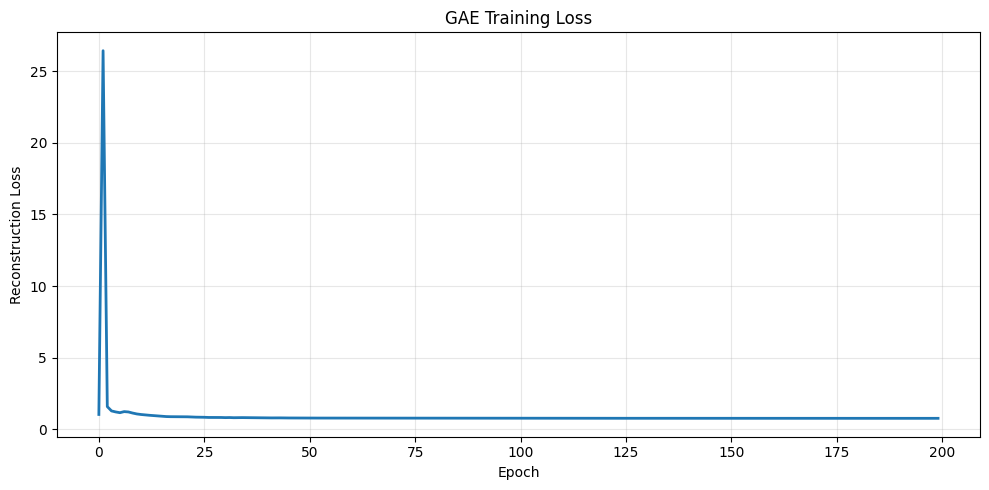


Loss improvement: 26.1%


In [6]:
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('GAE Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLoss improvement: {(losses[0] - losses[-1])/losses[0]*100:.1f}%")


## Save Model


In [7]:
from utils import save_model

model_path = Path(MODEL_DIR) / "gae_trained.pt"

save_model(
    model.cpu(),
    model_path,
    hyperparameters={
        'hidden_dim': HIDDEN_DIM,
        'latent_dim': LATENT_DIM,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    },
    metrics={
        'final_loss': losses[-1],
        'best_loss': min(losses)
    }
)

print(f"Model saved to: {model_path}")


Model saved to: models/gae_trained.pt
